## comparing NN to random forest for sonar/satellite data set

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os,sys
from rfpimp import oob_dropcol_importances, cv_importances, oob_importances, dropcol_importances, importances, plot_importances
from matplotlib.ticker import FormatStrFormatter

In [3]:
## define a function for calculating importances by MSE
def mse(model, X, y, sample_weights=None):
    y_pred = model.predict(X)
    mse = np.sum((y-y_pred)**2) / np.max(y.shape)
    return mse

In [4]:
## previous NN data organization
path = "/users/kellie/Documents/A College Life ^_^/CU Boulder/Earthlab - Analytics Hub/\
sonar_project/sonar-demo-master/sonar-demo-master/4km_sonardata/updated_nasc-sonar.csv"

d = pd.read_csv(path)

#dfile = '../data/2018-03-04_nasc-sonar.csv'
#d = pd.read_csv(dfile)

d = d.query('NASC > 0')  # filter out zero-value NASC
d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
d = d.assign(depth_m = d.depth_m.astype(np.float64))
d = d.query('log_nasc < 17.5')

feats = [
    'Lon', 
    'Lat',
    'distance_from_shore_m',
    'depth_m',
    'log_nasc', 
    'wavelength', 
    'depth_bin',
    'Day'
]
filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
d = d[filter_col]
d = d.dropna()

z = d[['Lat','Lon','closest_sst','closest_chlor_a','distance_from_shore_m','depth_m',\
        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
        'closest_Rrs_667','closest_Rrs_678','Day']]

wavelengths = d.wavelength.unique()
wavelengths.sort()
#wavelengths

depth_bins = d.depth_bin.unique()
#depth_bins

subd = d.query('wavelength == ' + str(wavelengths[0]))
subd = subd.query("depth_bin == '" + str(depth_bins[0]) + "'")
x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
x[:] = preprocessing.scale(x) # [:] retains dataframe
y = subd.log_nasc
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [4]:
## fit a MLP NN
mlp = MLPRegressor(hidden_layer_sizes=(50, 40, 30, 20, 10), max_iter=100000)
mlp.fit(x_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 40, 30, 20, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Neural Network

In [ ]:
## NN importances

# R2_test
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)
color = ['seagreen']#,'lightgreen','limegreen','darkseagreen','olivedrab','palegreen','forestgreen','mediumseagreen','darkgreen']

nn_r2_list = []
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):
        
        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        
        ## fit a MLP NN
        mlp = MLPRegressor(hidden_layer_sizes=(50, 40, 30, 20, 10), max_iter=100000)
        mlp.fit(x_train, y_train)

        ## calculate importances via permutation using model.score()
        nn_mlp_imp = importances(mlp, x_test, y_test)
        #print(type(mlp_imp))
        #print(mlp.score(x_test,y_test))
        nn_mlp_imp.Importance = np.abs(nn_mlp_imp.Importance.values)
        title = "wavelength={0}\n depth bin={1}\n R2_test={2:0.4f}".format(wavelengths[i], depth_bins[j], mlp.score(x_test, y_test))
        nn_mlp_imp.Importance.plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
        axes[j, i].set_title(title)
        
        # add model to lst of dfs...concatenate later
        #change title of columns in df from 'importance_x' to 'model...'
        nnr2_df = nn_mlp_imp.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
        nn_r2_list.append(nnr2_df)
        
    #print(mlp.score(x_test,y_test))  
plt.subplots_adjust(hspace=0.5)
fig.suptitle('NN -> MLP Variable Importances \n',fontsize=20)
plt.savefig('NN-MLP_var_importances.png')
plt.show()

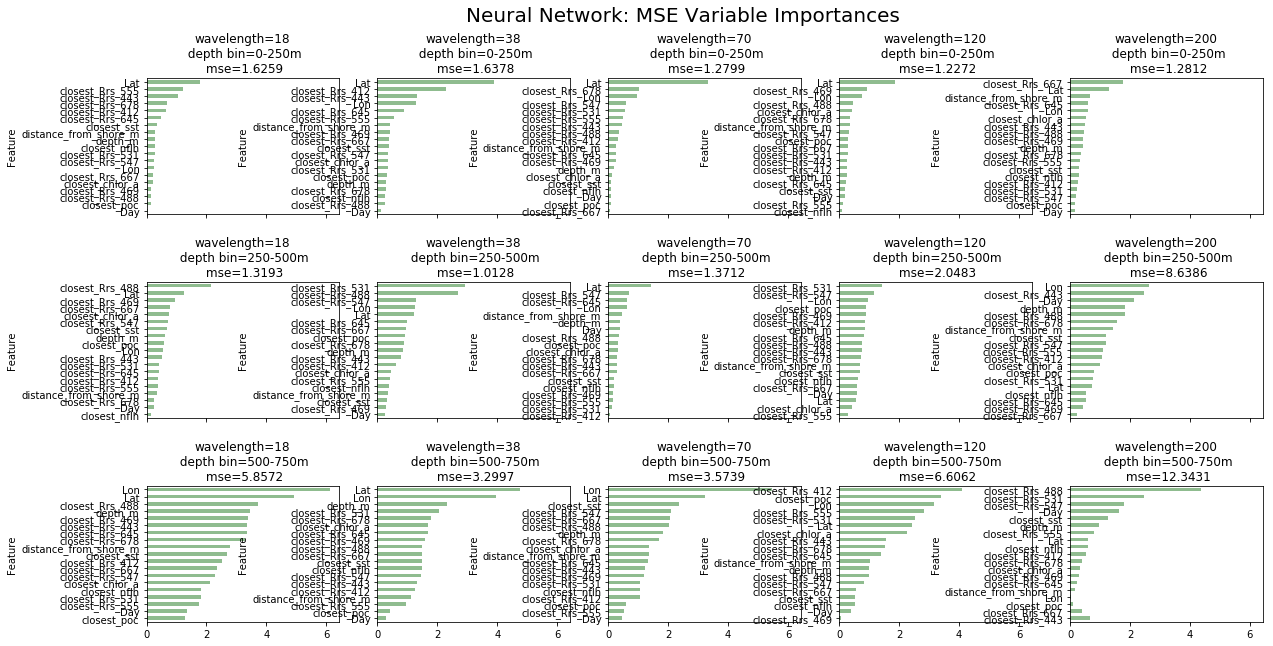

In [88]:
## NN importances, cont.

#MSE
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True,  figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)
nn_mse_list = []
nn_mse_dict = {}
nn_mse_list2 = []
color = ['darkseagreen']#,'olivedrab','palegreen','forestgreen','mediumseagreen','darkgreen']
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        
        ## fit a MLP NN
        mlp = MLPRegressor(hidden_layer_sizes=(50, 40, 30, 20, 10), max_iter=100000)
        mlp.fit(x_train, y_train)
        
        ## do the same for MSE
        mlp_imp_mse = importances(mlp, x_test, y_test, metric=mse)
        #nn_mse_list.append(mlp_imp_mse)
        title = "wavelength={0}\n depth bin={1}\n mse={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(mlp,x_test, y_test))
        mlp_imp_mse.Importance = np.abs(mlp_imp_mse.Importance.values)
        #plot_importances(mlp_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color) #sort helps keep same top-down look
       
        mlp_imp_mse.Importance.plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
        axes[j, i].set_title(title)
        
        # add model to lst of dfs...concatenate later
        #change title of columns in df from 'importance_x' to 'model...'
        nnmse_df = mlp_imp_mse.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
        nn_mse_list.append(nnmse_df)
        nn_mse_dict.update({f'{wavelengths[i]}_{depth_bins[j]}':mse(mlp,x_test, y_test)})  # actual mse values
        nn_mse_list2.append(mse(mlp,x_test, y_test))
        
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Neural Network: MSE Variable Importances \n',fontsize=20)
plt.savefig('NN-MSE_var_importances.png')
plt.show()


In [89]:
### df nn mse

# df: sort values descending and ascending values for max avg
from functools import reduce

# make row identifier "column" a real column
for i in nn_mse_list:
    i.reset_index(inplace=True)

# sort by mean model importance to determine sort order for plots
#print(df_list[0], (df_list[0]).shape)
df_nn_mse = reduce(lambda x, y: pd.merge(x, y, on = 'Feature'), nn_mse_list)
df_nn_mse

,Feature,Importance_18_0-250m,Importance_18_250-500m,Importance_18_500-750m,Importance_38_0-250m,Importance_38_250-500m,Importance_38_500-750m,Importance_70_0-250m,Importance_70_250-500m,Importance_70_500-750m,Importance_120_0-250m,Importance_120_250-500m,Importance_120_500-750m,Importance_200_0-250m,Importance_200_250-500m,Importance_200_500-750m
0,Day,0.061032,0.246043,1.357921,0.119048,0.236547,0.279569,0.076840,0.378515,0.459969,0.176240,0.588284,0.387981,0.170912,2.124009,1.622024
1,closest_poc,0.142017,0.598256,1.288428,0.332361,0.920259,0.428214,0.075952,0.324940,0.572372,0.306515,0.907436,3.382097,0.173231,0.791971,0.105657
2,closest_Rrs_488,0.148640,2.167161,3.736221,0.241370,2.697545,1.501820,0.353366,0.340339,2.021803,0.460738,0.764439,0.998817,0.461988,1.820887,4.366071
3,closest_Rrs_469,0.148802,0.965617,3.377250,0.417018,0.277875,1.592421,0.250675,0.156906,1.203847,0.929031,0.899284,0.057401,0.432350,0.422560,0.297302
4,closest_chlor_a,0.206557,0.749654,2.114208,0.356781,0.452363,1.688064,0.133778,0.319138,1.364058,0.416068,0.412818,2.247040,0.537070,1.004138,0.340815
5,closest_Rrs_667,0.223978,0.780928,2.367022,0.398363,0.948707,1.499822,0.061958,0.276428,2.054384,0.291686,0.589556,0.558883,1.750773,0.233772,0.409424
6,Lon,0.237187,0.561145,6.118313,1.293038,1.237773,3.973440,0.947717,0.609016,5.469106,0.758263,0.944904,3.151332,0.595583,2.645338,0.029100
7,closest_Rrs_547,0.242188,0.699673,2.291839,0.360148,1.270160,1.466809,0.590133,0.695234,2.106950,0.329541,1.169261,0.810450,0.209121,1.195644,1.803817
8,closest_Rrs_531,0.286531,0.430843,1.810220,0.342114,2.907448,2.044024,0.541378,0.127538,1.058012,0.290015,1.423742,2.513304,0.243379,0.775978,2.466825
9,closest_nflh,0.289916,0.161587,1.833215,0.254267,0.381644,1.487933,0.090648,0.171480,1.054325,0.091252,0.637858,0.530225,0.298799,0.544626,0.580149


## Random Forest

In [82]:
## Random Forest importances

## fit a RF to the same data
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(x_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

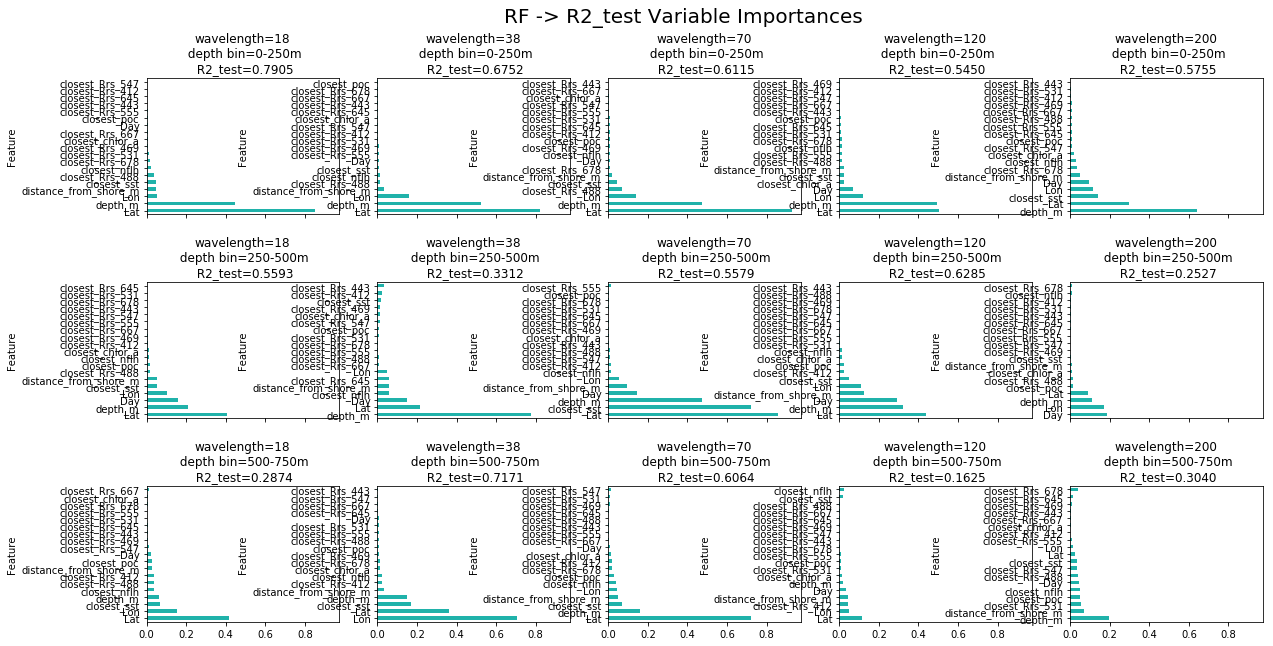

In [11]:
## Random Forest importances

# R2_test
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)
df_list = []
color = ['lightseagreen']#,'paleturquoise','lightskyblue','darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        rf.fit(x_train, y_train)
        
        ## calculate importances via permutation using model.score()
        perm_imp = importances(rf, x_test, y_test)
        #print(type(perm_imp))
        
        # add model to lst of dfs...concatenate later
        #change title of columns in df from 'importance_x' to 'model...'
        new_df = perm_imp.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
        df_list.append(new_df)
        
        
        title = "wavelength={0}\n depth bin={1}\n R2_test={2:0.4f}".format(wavelengths[i], depth_bins[j], rf.score(x_test, y_test))
        perm_imp.Importance = np.abs(perm_imp.Importance.values)
        perm_imp.Importance.plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
        axes[j, i].set_title(title)
        
        
plt.subplots_adjust(hspace=0.5)
fig.suptitle('RF -> R2_test Variable Importances \n\n',fontsize=20)
plt.savefig('RF-R2test_var_importances.png')
plt.show()

In [100]:
# df: sort values descending and ascending values for max avg
from functools import reduce

# make row identifier "column" a real column
for i in df_list:
    i.reset_index(inplace=True)

# sort by mean model importance to determine sort order for plots


#print(df_list[0], (df_list[0]).shape)
reduce(lambda x, y: pd.merge(x, y, on = 'Feature'), df_list)


ValueError: cannot insert level_0, already exists

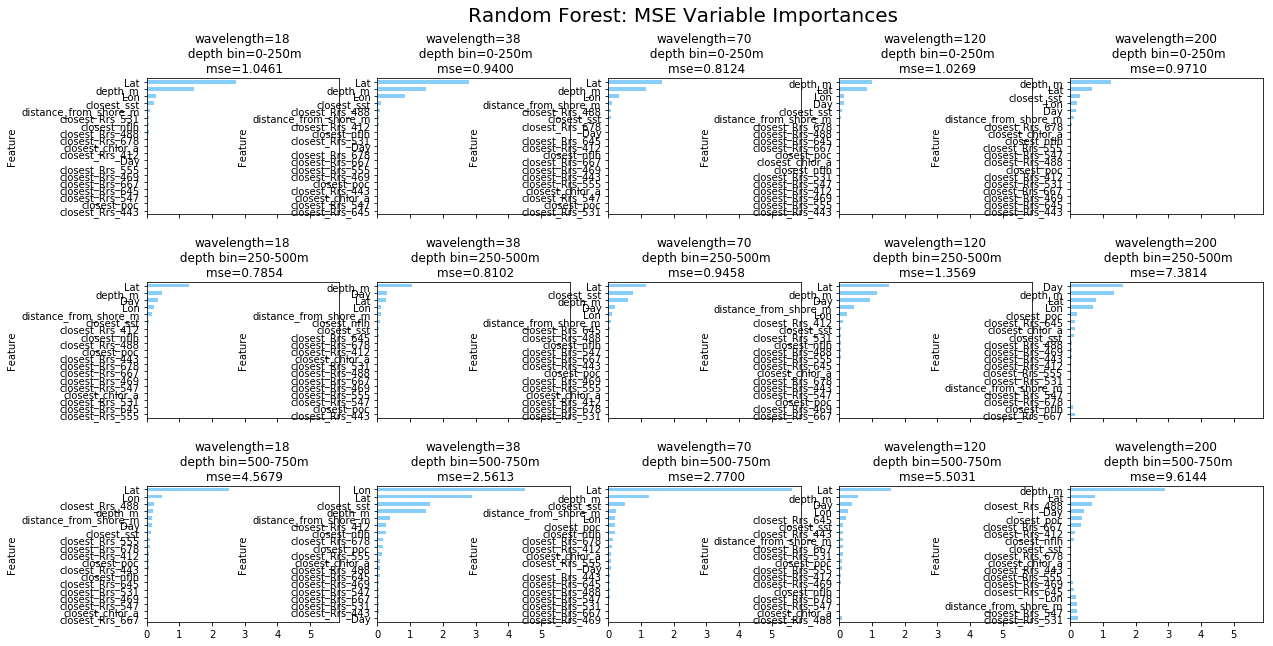

In [104]:
## Random Forest importances

# MSE
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

color = ['lightskyblue']#,'darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']

rf_mse_list = []
rf_mse_dict = {}
rf_mse_list2 = []
imps = []
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        rf.fit(x_train, y_train)
        
        ## do the same for mse
        rf_imp_mse = importances(rf, x_test, y_test, metric=mse)
        
        title = "wavelength={0}\n depth bin={1}\n mse={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(rf,x_test, y_test))
        rf_imp_mse.Importance = np.abs(rf_imp_mse.Importance.values)
        imps.append(np.abs(rf_imp_mse.Importance.values))
        
        #plot_importances(rf_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color)
        rf_imp_mse.Importance.plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
        axes[j, i].set_title(title)
        
        # add model to lst of dfs...concatenate later
        #change title of columns in df from 'importance_x' to 'model...'
        rfmse_df = rf_imp_mse.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
        rf_mse_list.append(rfmse_df)
        
        #new_df = rf_imp_mse.rename(index=str, columns={'Label':f'{wavelengths[i]}_{depth_bins[j]}'})
        rf_mse_dict.update({f'{wavelengths[i]}_{depth_bins[j]}':mse(rf,x_test, y_test)})  # actual mse values
        rf_mse_list2.append(mse(rf,x_test, y_test))

        
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Random Forest: MSE Variable Importances \n',fontsize=20)
plt.savefig('RF-MSE_var_importances.png')
plt.show()


In [200]:
### df rf mse

# df: sort values descending and ascending values for max avg
from functools import reduce

# make row identifier "column" a real column
for i in rf_mse_list:
    i.reset_index(inplace=True)

# sort by mean model importance to determine sort order for plots
#print(df_list[0], (df_list[0]).shape)
reduce(lambda x, y: pd.merge(x, y, on = 'Feature'), rf_mse_list)
#df_rf_mse

,index_x,Feature,Importance_18_0-250m,index_y,Importance_18_250-500m,index_x,Importance_18_500-750m,index_y,Importance_38_0-250m,index_x,...,index_x,Importance_120_250-500m,index_y,Importance_120_500-750m,index_x,Importance_200_0-250m,index_y,Importance_200_250-500m,index,Importance_200_500-750m
0,0,closest_Rrs_443,0.003478,8,0.018440,7,0.063123,3,0.009326,0,...,4,0.028668,12,0.126790,0,0.003351,8,0.041195,7,0.010313
1,1,closest_poc,0.000375,9,0.018966,8,0.075134,4,0.009950,1,...,2,0.018692,8,0.086343,6,0.021960,14,0.202847,14,0.350798
2,2,closest_Rrs_547,0.002897,4,0.007533,2,0.000404,1,0.003299,2,...,3,0.018922,2,0.009436,8,0.025141,3,0.003042,1,0.220015
3,3,closest_Rrs_645,0.007257,1,0.023094,5,0.011948,0,0.000096,11,...,7,0.036728,14,0.192946,1,0.003652,13,0.156540,4,0.127051
4,4,closest_Rrs_667,0.015169,6,0.012990,0,0.026053,7,0.018655,5,...,0,0.005699,10,0.112039,3,0.010192,0,0.148074,13,0.346003
5,5,closest_Rrs_469,0.016648,5,0.010979,3,0.006711,5,0.013459,4,...,1,0.009186,5,0.050014,2,0.007808,9,0.049361,5,0.100373
6,6,closest_Rrs_555,0.017215,0,0.026080,11,0.116505,6,0.015779,3,...,8,0.049330,7,0.082521,9,0.025180,6,0.038149,6,0.031691
7,7,Day,0.020367,16,0.357538,13,0.153658,9,0.024592,17,...,16,0.941273,16,0.393050,14,0.174672,18,1.609504,15,0.413835
8,8,closest_Rrs_412,0.021511,12,0.046532,9,0.084097,12,0.033201,9,...,13,0.108015,6,0.058254,5,0.015020,7,0.039584,12,0.133324
9,9,closest_chlor_a,0.021659,3,0.002748,1,0.023700,2,0.004354,8,...,6,0.032405,1,0.023968,11,0.036673,12,0.148706,8,0.001782


<class 'numpy.ndarray'>


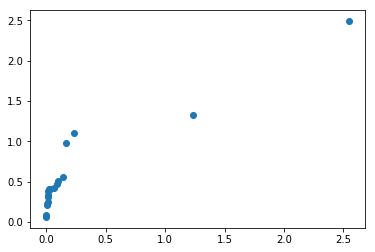

In [37]:
# testing  - need to add 1-to-1 line, model labels

df_rf_mse["Feature"]

df_rf_mse.columns[1:]
col_rfmse = df_rf_mse.columns[1:]
col_nnmse = df_nn_mse.columns[1:]
test1 = df_rf_mse[col_rfmse[0]].values
test2 = df_nn_mse[col_nnmse[0]].values

plt.scatter(test1,test2)
print(type(test1))

### Compare MSE for NN and RF

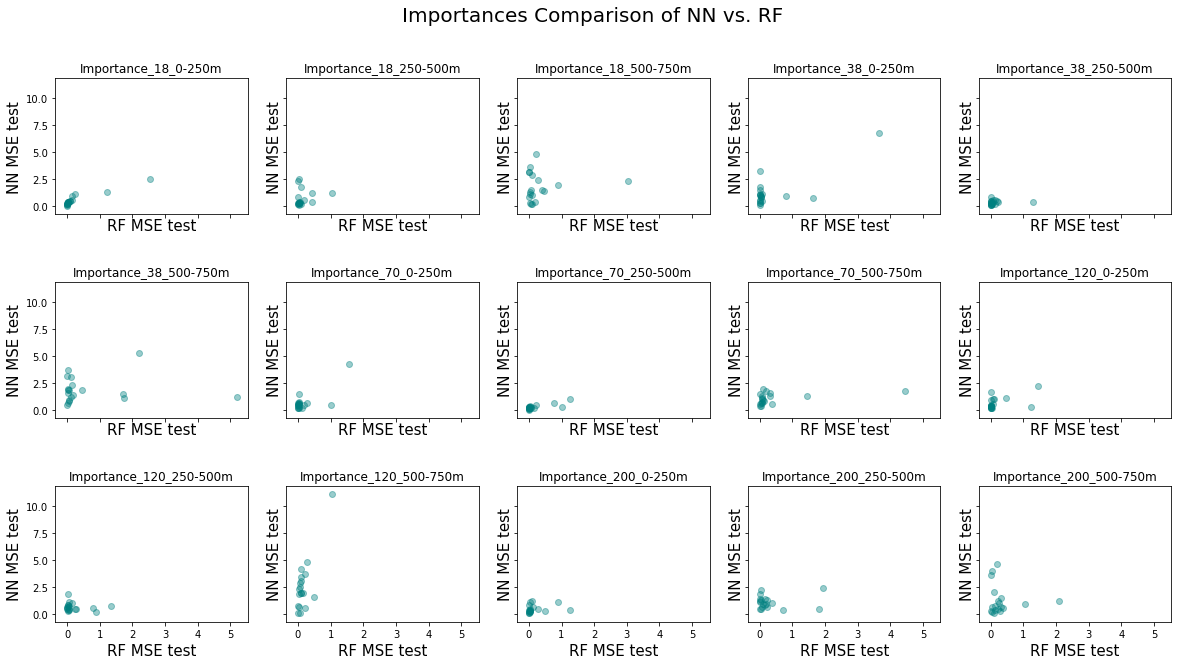

In [98]:
# df_nn_mse and df_rf_mse

# MSE comparison
fig, ax = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True,sharey=True, figsize=(20, 10))
#yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

col_rfmse = df_rf_mse.columns[1:]  # gets just the importances columns, not index or feature name columns
col_nnmse = df_nn_mse.columns[1:]

#yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)  # for one-to-one line

for k, element in enumerate(col_rfmse):

    the_nn = df_nn_mse[col_nnmse[k]].values
    the_rf = df_rf_mse[col_rfmse[k]].values
    ax = ax.flatten()
    ax[k].scatter(the_rf, the_nn, alpha=0.4, c='teal')
    #ax[k].plot(yrange, yrange, '--',c=k,alpha = 0.4)
    ax[k].set_title(col_rfmse[k])

    # add axis labels on the edge plots
    #if wavelength == wavelengths[0]:
    ax[k].set_ylabel('NN MSE test', fontsize = 15)
    #if depth_bin == depth_bins[-1]:
    ax[k].set_xlabel('RF MSE test', fontsize = 15)

plt.subplots_adjust(hspace=0.5)
fig.suptitle('Importances Comparison of NN vs. RF \n',fontsize=20)
plt.savefig('ImportancesComparison_nnrf.png')
plt.show()


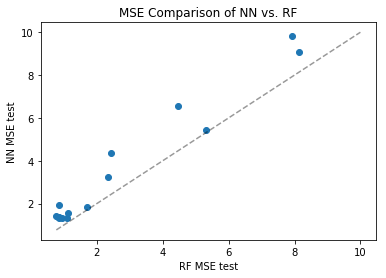

In [85]:
# nn_mse_list2 and rf_mse_list 2

yrange = np.linspace(min(min(nn_mse_list2),min(rf_mse_list2)), max(max(nn_mse_list2),max(rf_mse_list2), 10))  # for one-to-one line
#print(rf_mse_list2)
plt.scatter(rf_mse_list2,nn_mse_list2)
plt.plot(yrange, yrange, '--',c='k',alpha = 0.4)
plt.title('MSE Comparison of NN vs. RF')
plt.xlabel('RF MSE test')
plt.ylabel('NN MSE test')
#plt.legend()
plt.savefig('MSEcomparison_nn_rf_nolabels.png')
plt.show()

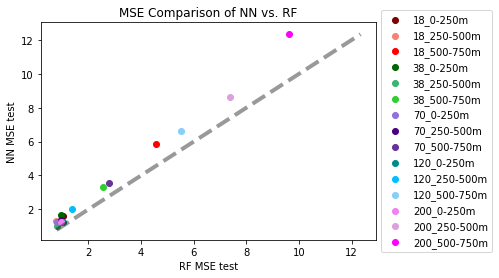

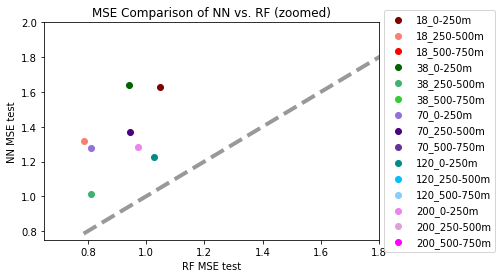

In [108]:
# trying to add labels via dict to mse comparison plot
# nn_mse_list2 and rf_mse_list 2

yrange = np.linspace(min(min(nn_mse_list2),min(rf_mse_list2)), max(max(nn_mse_list2),max(rf_mse_list2), 10))  # for one-to-one line

# need 15 different colors to cycle through for model visualization
colors = ['maroon','salmon','red',
         'darkgreen','mediumseagreen','limegreen',
         'mediumpurple','indigo','rebeccapurple',
         'darkcyan','deepskyblue','lightskyblue',
         'violet','plum','magenta']


rf7 = []
nn7 = []
labels7 = []
for key, value in rf_mse_dict.items():
    label = key
    rf7.append(rf_mse_dict[key])
    nn7.append(nn_mse_dict[key])
    labels7.append(label)
    #plt.scatter(rf_mse_dict[key],nn_mse_dict[key],label = label,alpha = 0.6)#,prop_cycle=(cycler('color', colors)))
    
#plt.plot(yrange, yrange, '--',c='k',alpha = 0.4)
#plt.title('MSE Comparison of NN vs. RF: using dict')
#plt.xlabel('RF MSE test')
#plt.ylabel('NN MSE test')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('MSEcomparison_nn_rf.png')
#plt.show()

###
fig, ax = plt.subplots()
for i,element in enumerate(rf1):
    ax.scatter(rf7[i],nn7[i],color=colors[i],label=labels7[i])
ax.plot(yrange, yrange, '--',c='k',alpha = 0.4)
plt.title('MSE Comparison of NN vs. RF')
plt.xlabel('RF MSE test')
plt.ylabel('NN MSE test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MSEcomparison_nn_rf_test7.png')
plt.show()
###


fig, ax = plt.subplots()
for i,element in enumerate(rf1):
    ax.scatter(rf7[i],nn7[i],color=colors[i],label=labels7[i])
ax.plot(yrange, yrange, '--',c='k',alpha = 0.4)
plt.title('MSE Comparison of NN vs. RF (zoomed)')
plt.xlabel('RF MSE test')
plt.ylabel('NN MSE test')
plt.xlim([0.65,1.8])
plt.ylim([0.75,2])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MSEcomparison_nn_rf_zoomed_test7.png')
plt.show()



use rf to see var importance across all models (use mse data, although both are same)
bar graph to show ranked importance: <br>
- make one graph showing the average importance of each var across all models
- sort based on most important (put at top)

In [205]:
col_rfmse = df_rf_mse.columns[1:]  # gets just the importances columns, not index or feature name columns
df_rf_mse.columns
col_list = list(df_rf_mse)

def remove_vals(the_list, val):
    return [value for value in the_list if value != val]

x = remove_vals(col_list, 'index_y')
y = remove_vals(x, 'index_x')
#print(y[1:])

df_rf_mse.drop(columns=['imp_sums','test'])
z = remove_vals(y, 'index')
b = remove_vals(z, 'imp_sums')
c = remove_vals(b, 'test')

#print(df_rf_mse.loc[[0]])
#print(df_rf_mse[y].loc[[0]])
df_rf_mse[c]

feature_sum = df_rf_mse[c].sum(axis=1)

#print(feature_sum)
feature_labels = df_rf_mse['Feature']
#print(feature_labels)
#df_rf_mse[c]
    

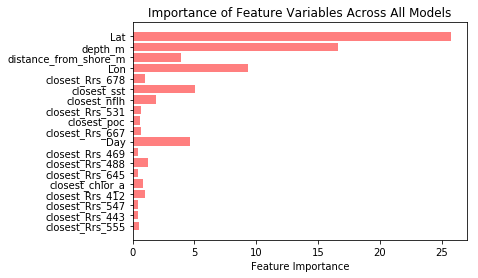

In [204]:
# ranking of var importances across all models while using rf

y_pos = np.arange(len(feature_labels))

plt.barh(y_pos, feature_sum, align='center', alpha=0.5)
plt.yticks(y_pos, feature_labels)
plt.xlabel('Feature Importance')
plt.title('Importance of Feature Variables Across All Models')
plt.savefig('importance_feature_variables_all_models.png')
plt.show()
 